### imports

In [1]:
!pip install -q pycocotools

In [2]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.3 MB/s eta 0:00:00


In [3]:
import os
import re
from torchmetrics import JaccardIndex
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
import time
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from torchsummary import summary
from torchvision.utils import save_image

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from matplotlib import pyplot as plt
from torchvision.io import read_image, ImageReadMode

from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
# from torch import nn

plt.ion()

### Load Data

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
TRAIN_SIZE = .75
BATCH_SIZE = 8
IMG_SIZE = 224
IMG_CHANNELS = 1
dataDir = 'drive/MyDrive/Colab Notebooks/the_lovely_bones/data/segm/'
modelDir = 'drive/MyDrive/Colab Notebooks/the_lovely_bones/data/models/'

# dataType = 'default'
# annFile = '{}annotations/instances_{}.json'.format(dataDir,dataType)
# ann_path = 'drive/MyDrive/Colab Notebooks/samolet/data/train/images/annotations/instances_default.json'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

# !pip install -q rasterio
# path = 'drive/MyDrive/Colab Notebooks/the_lovely_bones/Image_1_03.tif'
# from torchvision.transforms import ToTensor
# import rasterio
# from rasterio.plot import show

# with rasterio.open(path) as image:
#     image_array = image.read()


# torch_image = ToTensor()(image_array.astype('float'))
# print(torch_image.shape)
# torch_image = torch_image.permute(0, 2, 1)
# plt.imshow(torch_image)

In [8]:
print(len(os.listdir(dataDir + 'Images_1/')))
print(len(os.listdir(dataDir + 'Masks_1/')))

163
163


In [9]:
for f in os.listdir(dataDir + 'Images_1/'):
  if f not in os.listdir(dataDir + 'Masks_1/'):
    print(f)

251.jpg
252.jpg
254.jpg
253.jpg
250.jpg
255.jpg
262.jpg
263.jpg
264.jpg
268.jpg
265.jpg
266.jpg
267.jpg
256.jpg
257.jpg
258.jpg
259.jpg
260.jpg
261.jpg
269.jpg
270.jpg
271.jpg
273.jpg
272.jpg
274.jpg
275.jpg
276.jpg
277.jpg
279.jpg
278.jpg
280.jpg
281.jpg
282.jpg
283.jpg
284.jpg
285.jpg
286.jpg
288.jpg
287.jpg
289.jpg
290.jpg
291.jpg
292.jpg
293.jpg
294.jpg
295.jpg
296.jpg
297.jpg
299.jpg
298.jpg


In [10]:
for f in os.listdir(dataDir + 'Masks_1/'):
  if f not in os.listdir(dataDir + 'Images_1/'):
    print(f)

250.png
251.png
252.png
255.png
254.png
253.png
256.png
257.png
258.png
260.png
259.png
262.png
261.png
264.png
263.png
265.png
266.png
267.png
269.png
268.png
270.png
272.png
271.png
273.png
274.png
275.png
277.png
276.png
278.png
279.png
280.png
281.png
284.png
282.png
283.png
286.png
285.png
287.png
288.png
290.png
289.png
291.png
293.png
292.png
294.png
295.png
296.png
297.png
298.png
299.png


### Image preparation (contrast, etc...)

In [11]:
def contrast(img: np.array):
  clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8, 8))
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
  l, a, b = cv2.split(lab)  # split on 3 different channels
  l2 = clahe.apply(l)  # apply CLAHE to the L-channel
  lab = cv2.merge((l2, a, b))  # merge channels
  img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
  return img2

In [12]:
class SegmDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images_1"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Masks_1"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "Images_1", self.imgs[idx])
        mask_path = os.path.join(self.root, "Masks_1", self.masks[idx])
        img = read_image(img_path, ImageReadMode.GRAY)
        # img = torch.Tensor(contrast(cv2.imread(img_path))).permute(2, 0, 1) / 255
        mask = read_image(mask_path, ImageReadMode.GRAY)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [15]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [22]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    # transforms.append(T.Resize((224, 224)))
    return T.Compose(transforms)

import utils
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = SegmDataset(dataDir, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

In [17]:
# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.2923, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0818, grad_fn=<DivBackward0>), 'loss_objectness': tensor(6.1174, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(10.6593, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [23]:
from engine import train_one_epoch, evaluate
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and bone
num_classes = 2
# use our dataset and defined transformations
dataset = SegmDataset(dataDir, get_transform(train=True))
dataset_test = SegmDataset(dataDir, get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-80])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-80:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# summary(model, (3,224,224), batch_size=1)
# construct an optimizer


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [25]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 15 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=5)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/42]  eta: 0:01:14  lr: 0.000127  loss: 0.7542 (0.7542)  loss_classifier: 0.1189 (0.1189)  loss_box_reg: 0.3338 (0.3338)  loss_mask: 0.2065 (0.2065)  loss_objectness: 0.0341 (0.0341)  loss_rpn_box_reg: 0.0609 (0.0609)  time: 1.7685  data: 1.0176  max mem: 9219
Epoch: [0]  [ 5/42]  eta: 0:00:43  lr: 0.000736  loss: 0.7542 (0.9240)  loss_classifier: 0.1189 (0.1761)  loss_box_reg: 0.3046 (0.3396)  loss_mask: 0.2757 (0.2728)  loss_objectness: 0.0341 (0.0507)  loss_rpn_box_reg: 0.0609 (0.0847)  time: 1.1655  data: 0.4527  max mem: 9219
Epoch: [0]  [10/42]  eta: 0:00:32  lr: 0.001345  loss: 0.8986 (0.9770)  loss_classifier: 0.1854 (0.1867)  loss_box_reg: 0.3338 (0.3687)  loss_mask: 0.3187 (0.3043)  loss_objectness: 0.0341 (0.0420)  loss_rpn_box_reg: 0.0474 (0.0752)  time: 1.0021  data: 0.2602  max mem: 9219
Epoch: [0]  [15/42]  eta: 0:00:29  lr: 0.001954  loss: 0.8986 (1.0256)  loss_classifier: 0.1941 (0.2114)  loss_box_reg: 0.3338 (0.3841)  loss_mask: 0.3024 (0.2975)  loss_ob

In [26]:
torch.save(model.state_dict(), modelDir + 'mask_20.pth')
# torch.save(model, modelDir + 'mask_model.pth')

In [ ]:
# model.load_state_dict(torch.load(modelDir + 'mask.pth', map_location=torch.device(device)))

In [27]:
def test_mask(j, res, cont, dir, valid, thresh):
  name = os.listdir(os.path.join(dataDir, dir))[j]
  num = re.sub(r'\D', ''  , name)
  m_name = dataDir + 'Masks_1/' + num + '.png'
  image = read_image(dataDir + dir + name, ImageReadMode.GRAY)
  if valid:
    true_mask = read_image(m_name, ImageReadMode.GRAY)
    obj_ids = torch.unique(true_mask)
    obj_ids = obj_ids[1:]
    true_mask = (true_mask == obj_ids[:, None, None]).to(dtype=torch.bool).to(device)

  if cont:
    image = torch.Tensor(contrast(cv2.imread(dataDir + dir + name))).permute(2, 0, 1) / 255
  eval_transform = get_transform(train=False)

  model.eval()
  with torch.no_grad():
    x = eval_transform(image)
    if res:
      tr = T.Resize((224, 224))
      x = tr(x)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]
  scores = list(pred['scores'])
  imp = 0
  for sc in scores:
    if sc >= thresh:
      imp += 1
  labels = pred['labels'][:imp]
  boxes = pred['boxes'][:imp]
  masks = pred['masks'][:imp]


  image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
  if res:
      tr = T.Resize((224, 224))
      image = tr(image)
      if valid:
        true_mask = tr(true_mask)
  image = image[:3, ...]
  # pred_labels = [f"bone: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
  pred_labels = [f"bone: {score:.3f}" for label, score in zip(labels, scores)]
  pred_boxes = (boxes).long()
  output_image = draw_bounding_boxes(image, boxes, pred_labels, colors="red")

  masks = (pred["masks"] >= thresh).squeeze(1)
  if valid:
    t_mask = true_mask.squeeze(1)
    iou = []
    jaccard = JaccardIndex(task='multiclass', num_classes=2).to(device)
    for i in range(len(true_mask)):
      iou.append(jaccard(masks[i], t_mask[i]))
  output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")
  if valid:
    output_image = draw_segmentation_masks(output_image, t_mask, alpha=0.3, colors="green")

  plt.figure(figsize=(9, 9))
  plt.imshow(output_image.permute(1, 2, 0))
  plt.show()
  if valid:
    print('IoU --- ', iou, '\n')
  result = (len(masks), len(pred_boxes))
  # return thresholded

In [28]:
idx = np.random.randint(0, len(os.listdir(os.path.join(dataDir, "Images_1"))), 5)

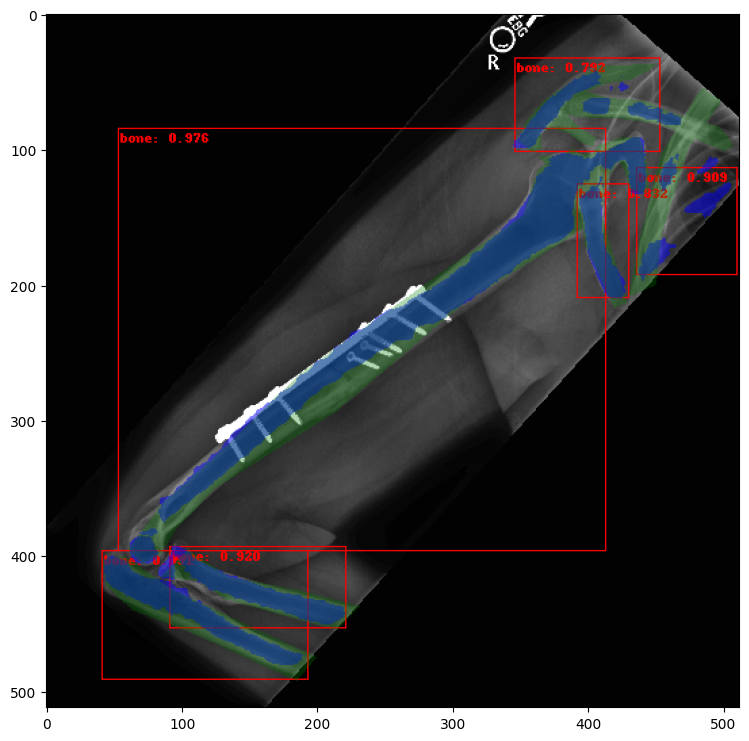

IoU ---  [tensor(0.4827, device='cuda:0'), tensor(0.8309, device='cuda:0'), tensor(0.5406, device='cuda:0'), tensor(0.7911, device='cuda:0'), tensor(0.4770, device='cuda:0'), tensor(0.5990, device='cuda:0')] 



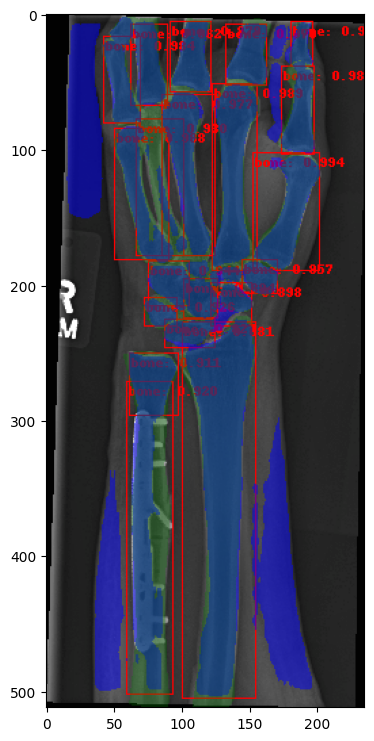

IoU ---  [tensor(0.4913, device='cuda:0'), tensor(0.4838, device='cuda:0'), tensor(0.4866, device='cuda:0'), tensor(0.4929, device='cuda:0'), tensor(0.4899, device='cuda:0'), tensor(0.8747, device='cuda:0'), tensor(0.4887, device='cuda:0'), tensor(0.4953, device='cuda:0'), tensor(0.4848, device='cuda:0'), tensor(0.8841, device='cuda:0'), tensor(0.4704, device='cuda:0'), tensor(0.4887, device='cuda:0'), tensor(0.4951, device='cuda:0'), tensor(0.4954, device='cuda:0'), tensor(0.4976, device='cuda:0'), tensor(0.4823, device='cuda:0'), tensor(0.4828, device='cuda:0'), tensor(0.8283, device='cuda:0'), tensor(0.4961, device='cuda:0')] 



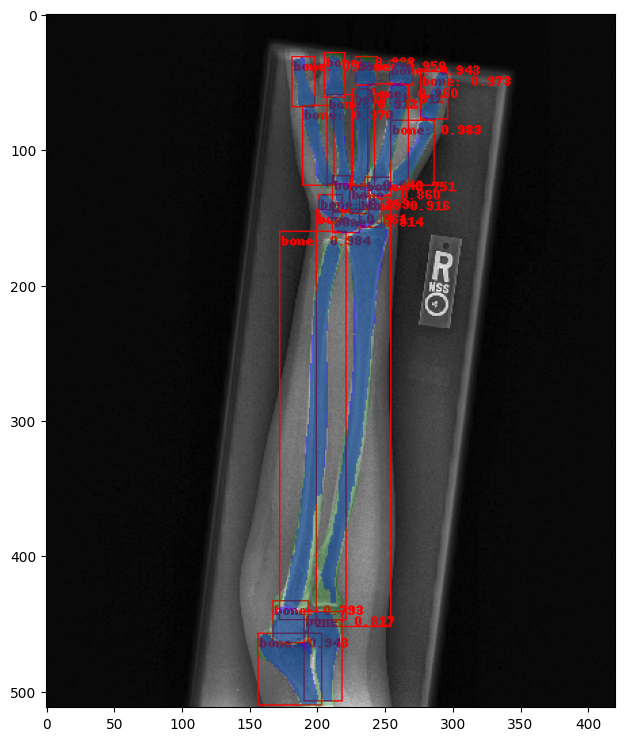

IoU ---  [tensor(0.4932, device='cuda:0'), tensor(0.4974, device='cuda:0'), tensor(0.4980, device='cuda:0'), tensor(0.4980, device='cuda:0'), tensor(0.7875, device='cuda:0'), tensor(0.4977, device='cuda:0'), tensor(0.4982, device='cuda:0'), tensor(0.4985, device='cuda:0'), tensor(0.4946, device='cuda:0'), tensor(0.4969, device='cuda:0'), tensor(0.4974, device='cuda:0'), tensor(0.4985, device='cuda:0'), tensor(0.4990, device='cuda:0'), tensor(0.4992, device='cuda:0'), tensor(0.4891, device='cuda:0'), tensor(0.4963, device='cuda:0'), tensor(0.4989, device='cuda:0'), tensor(0.4965, device='cuda:0')] 



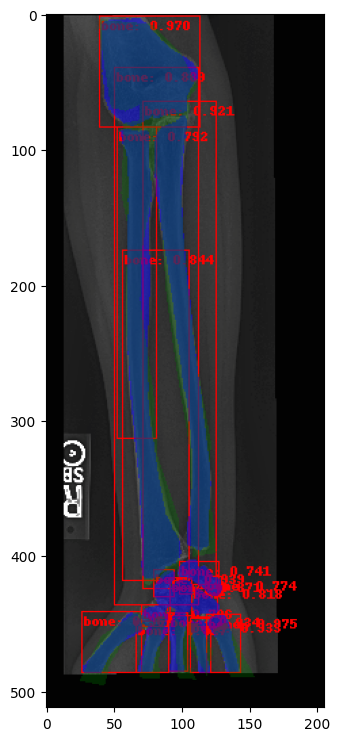

IoU ---  [tensor(0.4958, device='cuda:0'), tensor(0.4894, device='cuda:0'), tensor(0.4695, device='cuda:0'), tensor(0.4964, device='cuda:0'), tensor(0.4934, device='cuda:0'), tensor(0.4966, device='cuda:0'), tensor(0.7588, device='cuda:0'), tensor(0.4660, device='cuda:0')] 



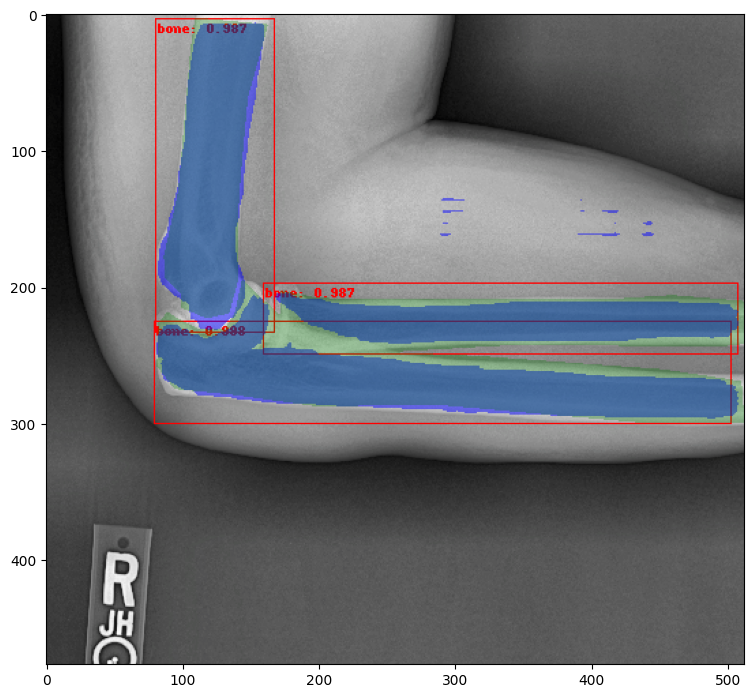

IoU ---  [tensor(0.8539, device='cuda:0'), tensor(0.8325, device='cuda:0'), tensor(0.9341, device='cuda:0')] 



In [29]:
for index in idx:
  test_mask(index, res=False, cont=True, dir='Images_1/', valid=True, thresh=.7)

smaller images

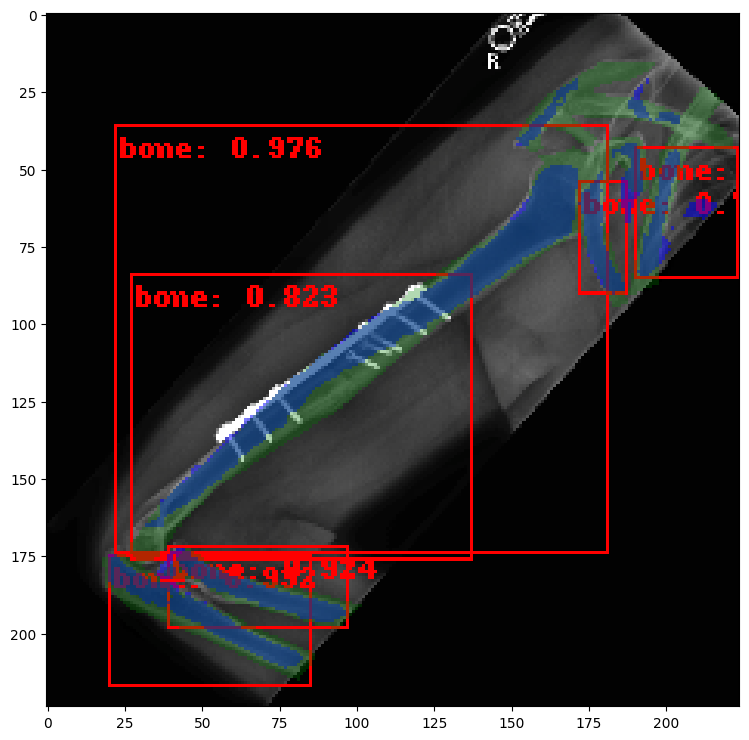

IoU ---  [tensor(0.4823, device='cuda:0'), tensor(0.4901, device='cuda:0'), tensor(0.4912, device='cuda:0'), tensor(0.4908, device='cuda:0'), tensor(0.5498, device='cuda:0'), tensor(0.4912, device='cuda:0')] 



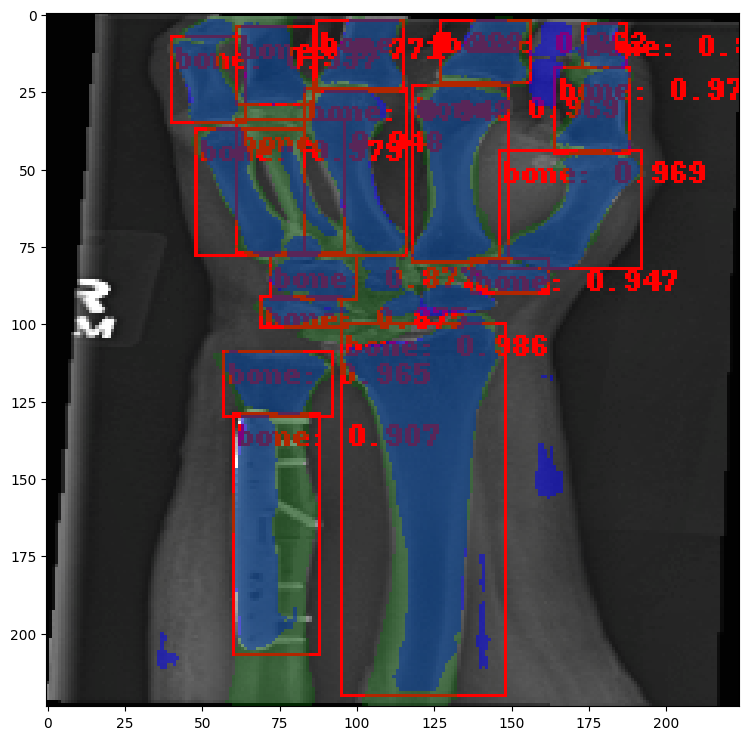

IoU ---  [tensor(0.4705, device='cuda:0'), tensor(0.4892, device='cuda:0'), tensor(0.4874, device='cuda:0'), tensor(0.4894, device='cuda:0'), tensor(0.4832, device='cuda:0'), tensor(0.4534, device='cuda:0'), tensor(0.4841, device='cuda:0'), tensor(0.4975, device='cuda:0'), tensor(0.4906, device='cuda:0'), tensor(0.4915, device='cuda:0'), tensor(0.4673, device='cuda:0'), tensor(0.4796, device='cuda:0'), tensor(0.4950, device='cuda:0'), tensor(0.4967, device='cuda:0'), tensor(0.4947, device='cuda:0'), tensor(0.4935, device='cuda:0'), tensor(0.4827, device='cuda:0'), tensor(0.4976, device='cuda:0'), tensor(0.4963, device='cuda:0')] 



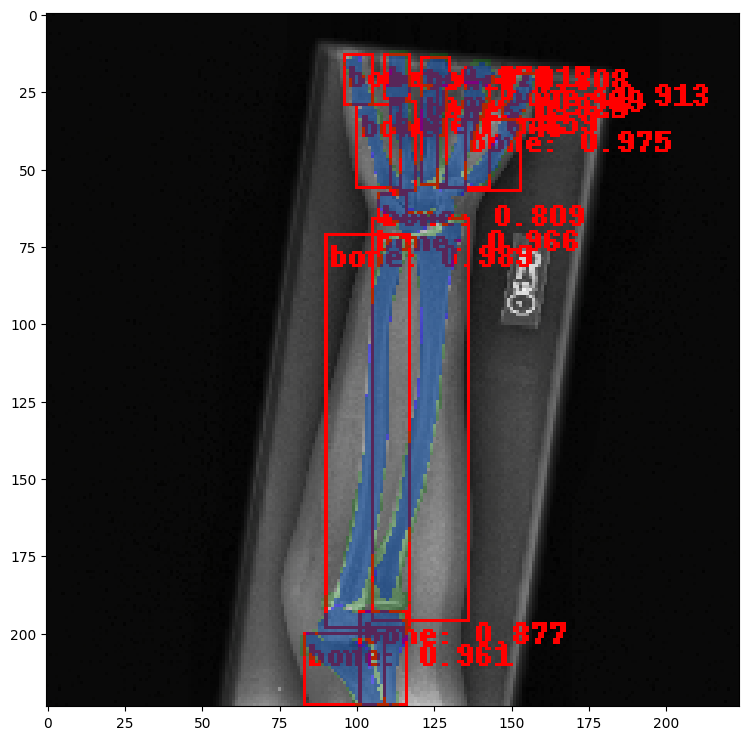

IoU ---  [tensor(0.4910, device='cuda:0'), tensor(0.4971, device='cuda:0'), tensor(0.4968, device='cuda:0'), tensor(0.4910, device='cuda:0'), tensor(0.4857, device='cuda:0'), tensor(0.4981, device='cuda:0'), tensor(0.4995, device='cuda:0'), tensor(0.4983, device='cuda:0'), tensor(0.4940, device='cuda:0'), tensor(0.4973, device='cuda:0'), tensor(0.4970, device='cuda:0'), tensor(0.4979, device='cuda:0'), tensor(0.9031, device='cuda:0'), tensor(0.4989, device='cuda:0'), tensor(0.4894, device='cuda:0'), tensor(0.4951, device='cuda:0'), tensor(0.4988, device='cuda:0'), tensor(0.4962, device='cuda:0')] 



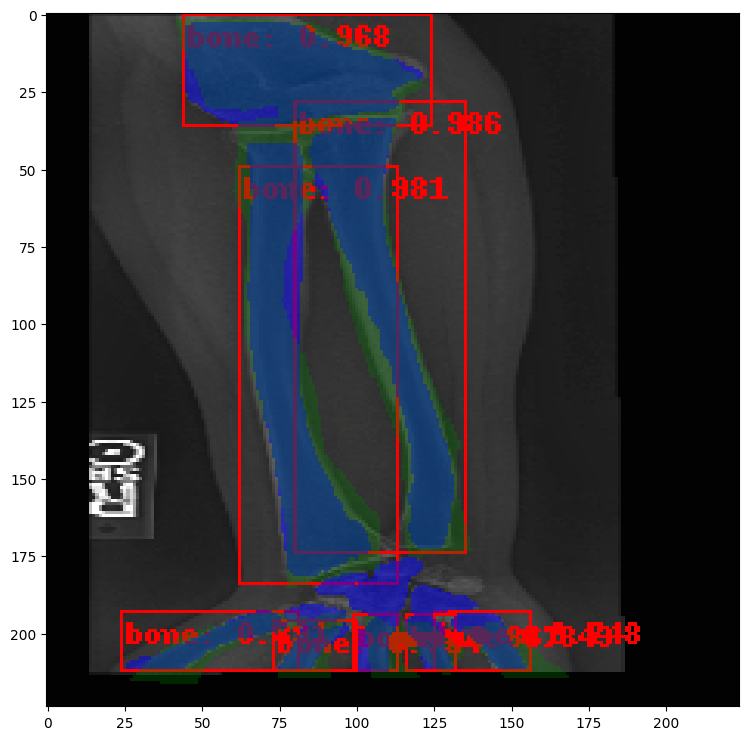

IoU ---  [tensor(0.4780, device='cuda:0'), tensor(0.4618, device='cuda:0'), tensor(0.4558, device='cuda:0'), tensor(0.4938, device='cuda:0'), tensor(0.4933, device='cuda:0'), tensor(0.4963, device='cuda:0'), tensor(0.4950, device='cuda:0'), tensor(0.4828, device='cuda:0')] 



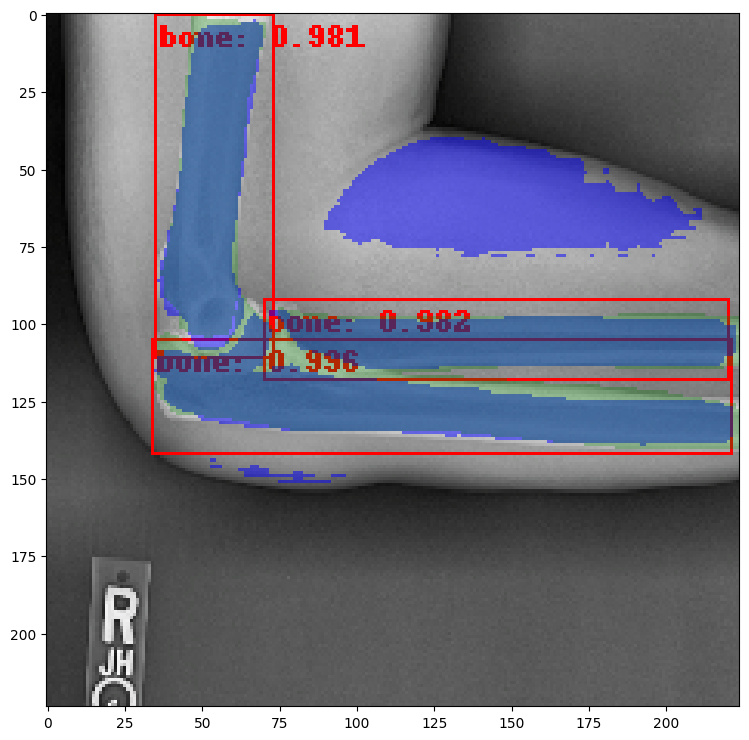

IoU ---  [tensor(0.8331, device='cuda:0'), tensor(0.8904, device='cuda:0'), tensor(0.9350, device='cuda:0')] 



In [30]:
for index in idx:
  test_mask(index, res=True, cont=True, dir='Images_1/', valid=True, thresh=.7)

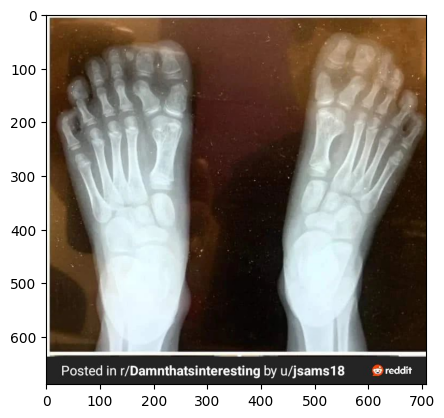

In [31]:
reddit = read_image(dataDir + 'test/Untitled.jpeg')
plt.imshow(reddit.permute(1,2,0))

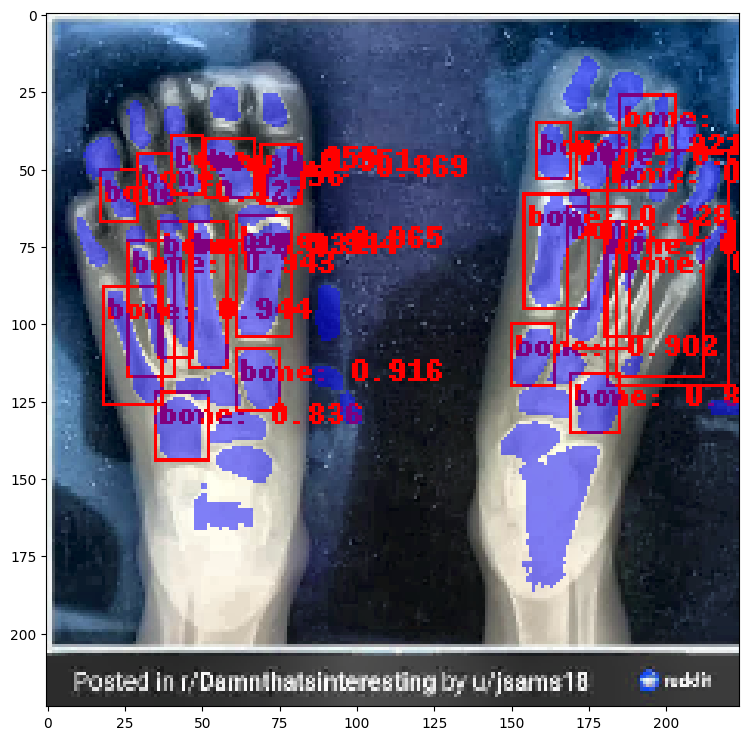

In [32]:
index = 0
test_mask(index, res=True, cont=True, dir='test/', valid=False, thresh=.8)

and it is scripts for data loaders

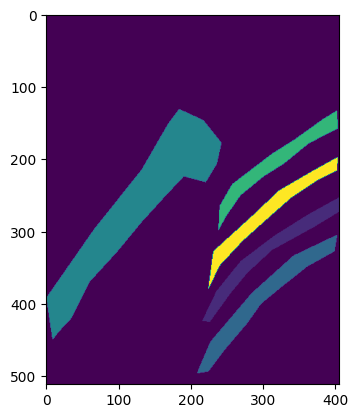

torch.Size([1, 512, 406])
6


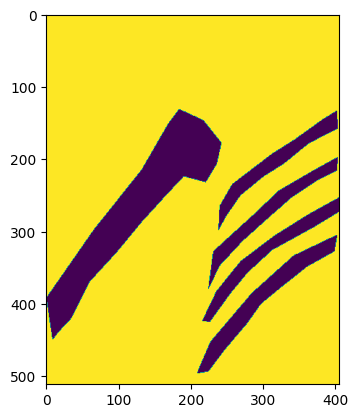

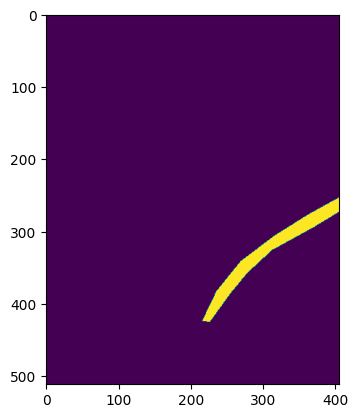

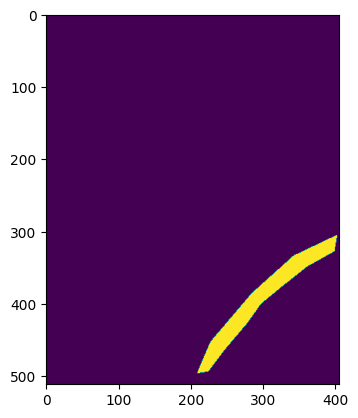

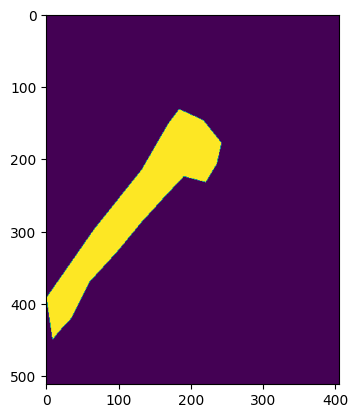

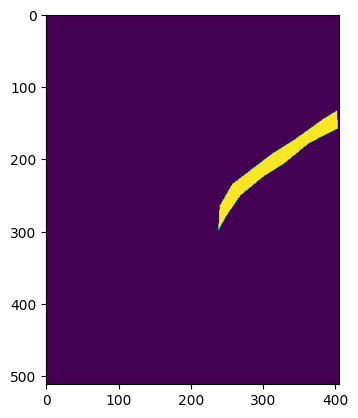

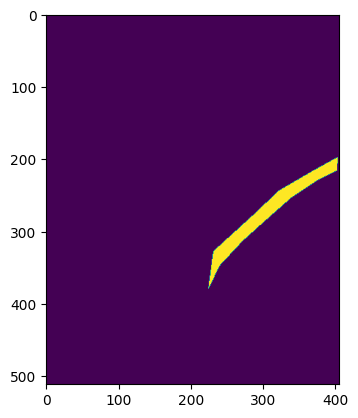

In [ ]:
Dir = 'drive/MyDrive/Colab Notebooks/the_lovely_bones/data/'
path_2 = Dir + '11.png'

mask = read_image(path_2, ImageReadMode.GRAY)
plt.imshow(mask.permute(1, 2, 0))
plt.show()
print(mask.shape)
obj_ids = torch.unique(mask)
# obj_ids = obj_ids[1:]
num_objs = len(obj_ids)
print(num_objs)
masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
for m in masks:
  plt.imshow(m)
  plt.show()